In [8]:
import numpy as np 
import os, sys, glob, csv
import pandas as pd
import time, datetime
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot  as plt 
import matplotlib as mpl
from astropy.table import Table,vstack,unique,Column
from astropy.time import Time
import pylab as py


In [9]:
def get_leginfo(misfile):
    
    leginfo =[]

    with open(misfile, 'r') as rf:
        for line_file in rf:
            if 'Takeoff:' in line_file:
                utc_date = line_file.split("Takeoff: ")[1].split(' ')[0]
            if ("Leg" in line_file) & ("Start" in line_file):
                st = line_file.split("Start: ")[1].split('Leg Dur:')[0]
                obj = line_file.split("(")[1].split(')')[0]
                dur = line_file.split('Leg Dur: ')[1].split(' Alt.:')[0]
                alt = line_file.split(' Alt.: ')[1].split('000 ft')[0]
#                 print(st,obj,dur,alt)
                
#                 if '/' in alt:
#                     print(np.int(alt.split('/')[-1]),np.int(alt.split('/')[0])/1000)
#                     alt = int(np.mean([np.int(alt.split('/')[-1]),np.int(alt.split('/')[0])/1000]))
                   
                leginfo.append((pd.to_datetime(utc_date+' '+st.strip()),obj.strip(),dur.strip(),str(alt)))

        tms=[]
        for i in range(3,len(leginfo)-1):
            legnum=i
            x=leginfo[legnum][0]+pd.DateOffset(hours=-7)
            print(x, str(leginfo[legnum][1]))
            tms.append(x)

        ltags = [leginfo[i][1] for i in range(3,len(leginfo)-1)]
        ldurs = [leginfo[i][2] for i in range(3,len(leginfo)-1)]
        alts = [leginfo[i][3] for i in range(3,len(leginfo)-1)]

                
    return leginfo,tms,ltags,ldurs,alts


In [34]:
fp = '/Users/seftekh1/Desktop/my_corner/ADRstudy/'

mis = fp+'202205_HA_QUIGON_WX12.mis'
fnum,date = 882,'06-03-2022'

leginfo,tms,ltags,ldurs,alts = get_leginfo(mis)
print(ltags,ldurs)

2022-06-03 21:00:30 Setup
2022-06-03 21:31:10 PolarisFlare-1
2022-06-03 23:22:54 NGC4736
2022-06-04 00:20:17 G24_F1
2022-06-04 03:18:04 4 Vesta
2022-06-04 04:30:34 cage
['Setup', 'PolarisFlare-1', 'NGC4736', 'G24_F1', '4 Vesta', 'cage'] ['00:30:00', '01:50:00', '00:54:00', '02:56:00', '01:10:00', '00:05:00']


In [35]:
 #fp = '/home/sarah/ADRstudy/'
fp = '/Users/seftekh1/Desktop/my_corner/ADRstudy/'
mis = fp+'202205_HA_QUENTIN_WX12.mis'
fnum,date = 881,'06-02-2022'


leginfo,tms,ltags,ldurs,alts = get_leginfo(mis)
print(leginfo)

2022-06-02 21:00:02 Setup
2022-06-02 21:30:43 PolarisFlare-1
2022-06-02 23:22:24 NGC4736
2022-06-03 00:21:47 G24_F1
2022-06-03 03:16:33 4 Vesta
2022-06-03 04:28:47 cage
[(Timestamp('2022-06-03 03:30:00'), 'Departure', '00:02:20', '10'), (Timestamp('2022-06-03 03:35:12'), 'PSP', '00:10:01', '35'), (Timestamp('2022-06-03 03:45:41'), 'Dead Leg', '00:14:00', '35'), (Timestamp('2022-06-03 04:00:02'), 'Setup', '00:30:00', '37'), (Timestamp('2022-06-03 04:30:43'), 'PolarisFlare-1', '01:50:00', '39'), (Timestamp('2022-06-03 06:22:24'), 'NGC4736', '00:56:00', '41'), (Timestamp('2022-06-03 07:21:47'), 'G24_F1', '02:53:00', '41000/60/43'), (Timestamp('2022-06-03 10:16:33'), '4 Vesta', '01:10:00', '43'), (Timestamp('2022-06-03 11:28:47'), 'cage', '00:05:00', '43'), (Timestamp('2022-06-03 11:33:59'), 'Approach via ETHER', '00:30:32', '43')]


In [11]:

fp = '/Users/seftekh1/Desktop/my_corner/ADRstudy/'
mis = fp+'202205_HA_QUENTIN_WX12.mis'
fnum = 881

hkpath= fp+'/hk/'
mrf = hkpath+'06022022/220602_LHe_Flight-mrf.tsv'
hk =  pd.read_csv(mrf, delim_whitespace=True,
                      names=['DATA','col','Time_sec','Temp_K','Resistence',
                             'Voltage','Current','mmddyyyy','hhmmss'])


df = pd.read_csv(fp+'isotime_F881.csv',skiprows=1,
                      names=['unixdatetime', 'nanosec', 'ta_ex', 'ta_xel', 'ta_los', 'si_el',
       'si_xel', 'si_los', 'isotime','hour','ymdhms'],parse_dates=[8,10])
#df.info()



In [12]:
# %%timeit
hkpath= fp+'/hk/'
mrf = hkpath+'06022022/220602_LHe_Flight-mrf.tsv'
hk =  pd.read_csv(mrf, delim_whitespace=True,
                      names=['DATA','col','Time_sec','Temp_K','Resistence',
                             'Voltage','Current','mmddyyyy','hhmmss'])

timedelta = pd.Timedelta(0,unit= 'm')
hk['time_str'] = hk.apply(lambda x: x['mmddyyyy']+' '+x['hhmmss'],axis=1)
hk['timestamp'] = pd.to_datetime(hk['time_str'])-timedelta
# hk['timestamp'] = hk['timestamp'].dt.tz_localize('US/pacific').dt.tz_convert('utc')
#nhk = hk.set_index('timestamp')

nhk= hk.set_index('timestamp')
nhk = nhk.resample("20s").mean()
nhk["C_120"] = nhk["Current"].shift(6)

nhk["AmpHour"] = 3600*(nhk["Current"] - nhk["C_120"])/120

print(len(hk.time_str.values),hk.timestamp.values[0],(hk.timestamp.values[-1]),len(hk.timestamp.values))
hk.info(),nhk.info()



2229 2022-06-02T18:28:22.000000000 2022-06-03T05:20:51.000000000 2229
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATA        2229 non-null   object        
 1   col         2229 non-null   object        
 2   Time_sec    2229 non-null   float64       
 3   Temp_K      2229 non-null   float64       
 4   Resistence  2229 non-null   float64       
 5   Voltage     2229 non-null   float64       
 6   Current     2229 non-null   float64       
 7   mmddyyyy    2229 non-null   object        
 8   hhmmss      2229 non-null   object        
 9   time_str    2229 non-null   object        
 10  timestamp   2229 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 191.7+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1958 entries, 2022-06-02 18:28:20 to 2022-06-03 05:20:40
Freq: 20S
Data c

(None, None)

In [13]:
ndf = df.set_index('isotime')
per17sec = pd.DataFrame()

per17sec['si_el'] = ndf.si_el.resample('17s').mean()
per17sec['si_xel'] = ndf.si_xel.resample('17s').mean()
per17sec['si_los'] = ndf.si_los.resample('17s').mean()

# len(df.si_los.values),len(per17sec['si_los']),

print(ndf.head())
per17sec.info(),hk.info(),ndf.info()

                            unixdatetime    nanosec     ta_ex    ta_xel  \
isotime                                                                   
2022-06-02 19:14:06.804575    1654222446  804574600 -0.023353  7.577155   
2022-06-02 19:14:06.807074    1654222446  807074100 -0.016264  7.569679   
2022-06-02 19:14:06.809574    1654222446  809574100 -0.009555  7.568437   
2022-06-02 19:14:06.812074    1654222446  812074100 -0.019806  7.581664   
2022-06-02 19:14:06.814574    1654222446  814574100 -0.018918  7.582676   

                              ta_los     si_el    si_xel    si_los      hour  \
isotime                                                                        
2022-06-02 19:14:06.804575 -6.188050 -0.009937  7.574255 -6.213499  0.000223   
2022-06-02 19:14:06.807074 -6.184926 -0.048068  7.587528 -6.197619  0.000224   
2022-06-02 19:14:06.809574 -6.179207 -0.056323  7.573750 -6.204784  0.000225   
2022-06-02 19:14:06.812074 -6.177409 -0.004706  7.581382 -6.202508  0.0002

(None, None, None)

### MCCS House keeping 50Hz data is archived in UTC time, converting them back to local before adding to ADR HK dataframe


In [14]:
fp50 = '/Users/seftekh1/Desktop/my_corner/ADRstudy/50hz_sensordata_OC9Q/'
f50name = 'ta_tsc_tsc_mcs_hk_F'+str(fnum)+'.csv'

df5 = pd.read_csv(fp50+f50name, delimiter=',',
             names=['unixdatetime','nanosec','atc_el','atc_xel','atc_los'],skiprows=1)
df5.unixdatetime = pd.to_datetime(df5.unixdatetime)-pd.DateOffset(hours=7)  ### UTC to Local PT
df5.rename(columns = {'unixdatetime':'timestamp'}, inplace = True)

ndf5 = df5.set_index('timestamp')

df5p17 = pd.DataFrame()#ndf5[['timestamp','atc_el','atc_xel','atc_los']]


df5p17['atc_el'] = ndf5.atc_el.resample('17s').mean()
df5p17['atc_xel'] = ndf5.atc_xel.resample('17s').mean()
df5p17['atc_los'] = ndf5.atc_los.resample('17s').mean()

df5p17.reset_index(inplace=True)


ndf5.info(), df5p17.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 967614 entries, 2022-06-02 17:30:00.188000 to 2022-06-03 05:15:29.989000
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   nanosec  967614 non-null  float64
 1   atc_el   967614 non-null  float64
 2   atc_xel  967614 non-null  float64
 3   atc_los  967614 non-null  float64
dtypes: float64(4)
memory usage: 36.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491 entries, 0 to 2490
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2491 non-null   datetime64[ns]
 1   atc_el     2491 non-null   float64       
 2   atc_xel    2491 non-null   float64       
 3   atc_los    2491 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 78.0 KB


(None, None)

In [15]:
len(df5p17), len(nhk), len(per17sec)

(2491, 1958, 2158)

In [16]:
df5p17.head()

,timestamp,atc_el,atc_xel,atc_los
0,2022-06-02 17:29:45,0.000004,-0.000087,0.000003
1,2022-06-02 17:30:02,0.000001,-0.000012,0.000068
2,2022-06-02 17:30:19,-0.000004,0.000040,0.000058
3,2022-06-02 17:30:36,0.000011,0.000050,0.000056
4,2022-06-02 17:30:53,0.000005,0.000005,0.000069


In [17]:
nhk.head()

,Time_sec,Temp_K,Resistence,Voltage,Current,C_120,AmpHour
timestamp,,,,,,,
2022-06-02 18:28:20,23457.6585,0.227376,43681.5,0.232735,2.579415,NaN,NaN
2022-06-02 18:28:40,23483.8090,0.198711,54643.0,0.124020,2.264578,NaN,NaN
2022-06-02 18:29:00,23501.0610,0.200597,53409.0,-0.021860,2.272243,NaN,NaN
2022-06-02 18:29:20,23518.4740,0.199921,53846.0,0.007370,2.270672,NaN,NaN
2022-06-02 18:29:40,23535.9340,0.200005,53791.0,0.003750,2.273602,NaN,NaN


In [18]:
per17sec.head()

,si_el,si_xel,si_los
isotime,,,
2022-06-02 19:14:01,-0.039949,7.576478,-6.199276
2022-06-02 19:14:18,-0.039861,7.576147,-6.199684
2022-06-02 19:14:35,-0.040045,7.575925,-6.199949
2022-06-02 19:14:52,-0.040044,7.576040,-6.200054
2022-06-02 19:15:09,-0.040013,7.575940,-6.200092


In [19]:
per17sec
nhk

df_join = df5p17.set_index("timestamp").join(per17sec, how="outer")
df_join = df_join.join(nhk, how="outer")

# df_join = df_join.resample("17s").mean()

df_join.head()

,atc_el,atc_xel,atc_los,si_el,si_xel,si_los,Time_sec,Temp_K,Resistence,Voltage,Current,C_120,AmpHour
2022-06-02 17:29:45,0.000004,-0.000087,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02 17:30:02,0.000001,-0.000012,0.000068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02 17:30:19,-0.000004,0.000040,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02 17:30:36,0.000011,0.000050,0.000056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02 17:30:53,0.000005,0.000005,0.000069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# columns to be filled
cols = df_join.columns #["atc_el", "atc_xel", "atc_los", "si_el", "si_xel", "si_los"]

df_filled = df_join[cols].interpolate(method='linear', limit_direction='forward', axis=0)

# adding other columns back in the df_filled
for col in df_join.columns:
    if col not in cols:
        df_filled[col] = df_join[col]

df_filled.loc["2022-06-02 18:28:00":"2022-06-02 18:30"]

,atc_el,atc_xel,atc_los,si_el,si_xel,si_los,Time_sec,Temp_K,Resistence,Voltage,Current,C_120,AmpHour
2022-06-02 18:28:07,-0.000004,1.196038e-05,0.000085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02 18:28:20,-0.000004,6.983554e-06,0.000092,NaN,NaN,NaN,23457.658500,0.227376,43681.500000,0.232735,2.579415,NaN,NaN
2022-06-02 18:28:24,-0.000004,2.006732e-06,0.000100,NaN,NaN,NaN,23470.733750,0.213044,49162.250000,0.178377,2.421997,NaN,NaN
2022-06-02 18:28:40,-0.000012,5.133942e-06,0.000086,NaN,NaN,NaN,23483.809000,0.198711,54643.000000,0.124020,2.264578,NaN,NaN
2022-06-02 18:28:41,-0.000020,8.261151e-06,0.000071,NaN,NaN,NaN,23489.559667,0.199340,54231.666667,0.075393,2.267133,NaN,NaN
2022-06-02 18:28:58,-0.000011,9.081317e-06,0.000071,NaN,NaN,NaN,23495.310333,0.199969,53820.333333,0.026767,2.269688,NaN,NaN
2022-06-02 18:29:00,0.000003,2.006345e-05,0.000068,NaN,NaN,NaN,23501.061000,0.200597,53409.000000,-0.021860,2.272243,NaN,NaN
2022-06-02 18:29:15,0.000018,3.104557e-05,0.000064,NaN,NaN,NaN,23509.767500,0.200259,53627.500000,-0.007245,2.271457,NaN,NaN
2022-06-02 18:29:20,0.000012,3.300214e-05,0.000061,NaN,NaN,NaN,23518.474000,0.199921,53846.000000,0.007370,2.270672,NaN,NaN
2022-06-02 18:29:32,0.000006,3.495871e-05,0.000059,NaN,NaN,NaN,23527.204000,0.199963,53818.500000,0.005560,2.272137,NaN,NaN


<AxesSubplot:>

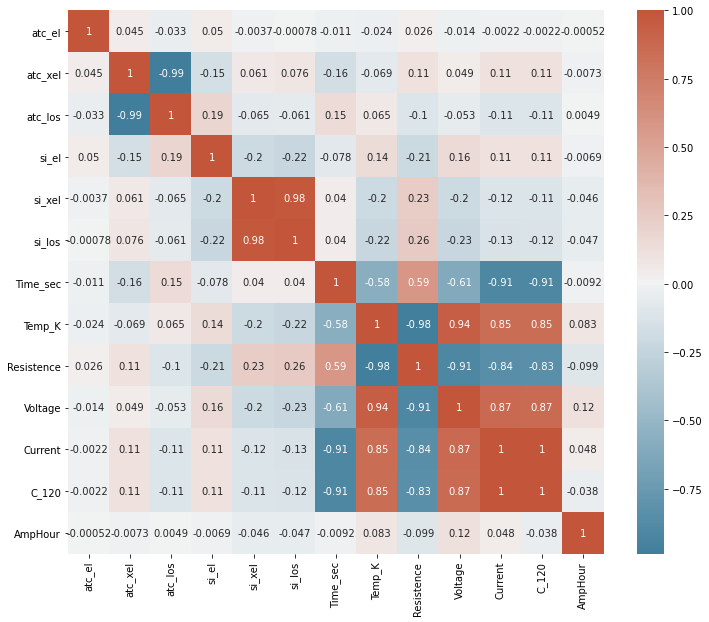

In [21]:
import seaborn as sns

#
# Correlation between different variables
#
corr = df_filled.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = None, cmap=cmap)



<AxesSubplot:>

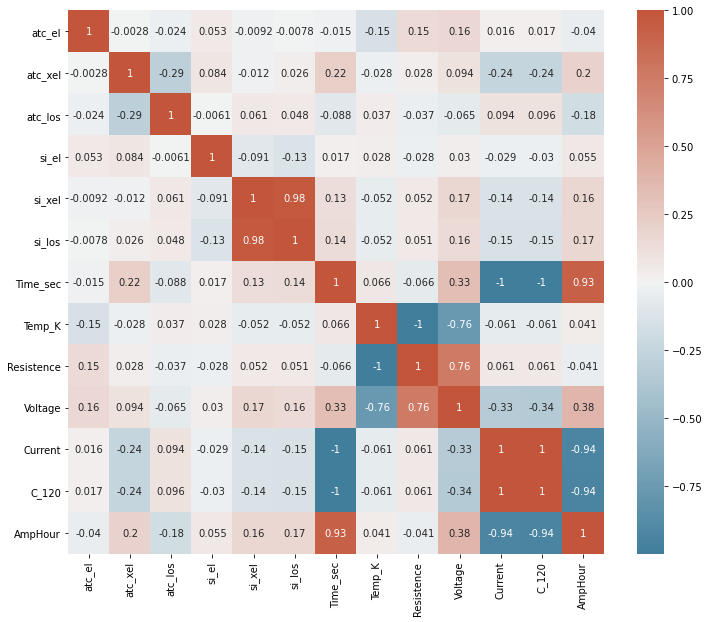

In [23]:
data = df_filled.loc[tms[1]:tms[2]]
N = len(data)
data = data.iloc[int(0.15*N):int(0.85*N)]

corr = data.corr()

#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = None, cmap=cmap)



Text(0, 0.5, 'F881_si_xel')

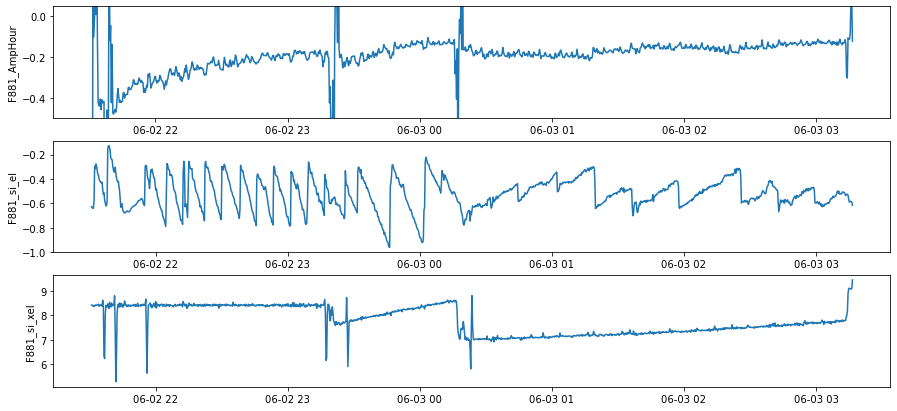

In [41]:
leg = 1

data = df_filled.loc[tms[leg]:tms[leg+1]]

N = len(data)
data = data.iloc[int(0.15*N):int(0.85*N)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(nhk.loc[tms[leg]:tms[leg+3]].AmpHour)
ax1.set_ylim(-0.5,0.05)
ax1.set_ylabel('F'+str(fnum)+"_AmpHour")

ax2.plot(per17sec.loc[tms[leg]:tms[leg+3]].si_el)
ax2.set_ylabel('F'+str(fnum)+"_si_el")

ax3.plot(per17sec.loc[tms[leg]:tms[leg+3]].si_xel)
ax3.set_ylabel('F'+str(fnum)+"_si_xel")


<ipython-input-42-50cba306fafe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["AmpHour_avg"] = data.AmpHour.rolling(window=70, center=True).mean()


Text(0, 0.5, 'F881_si_xel')

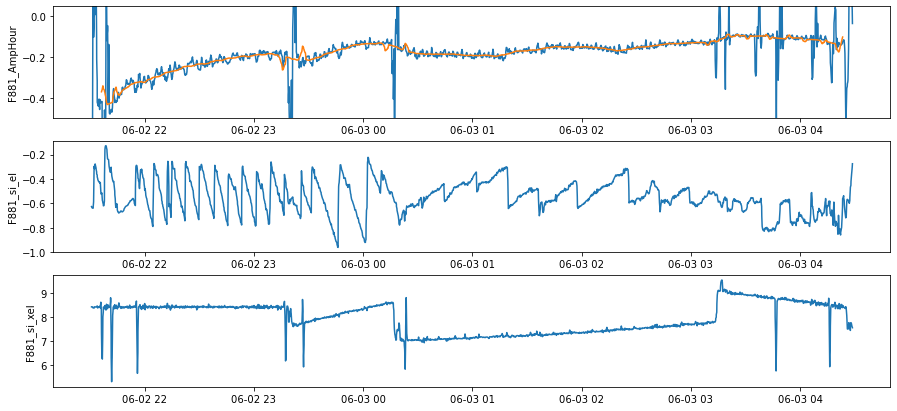

In [42]:
leg = 1

data = df_filled.loc[tms[leg]:tms[leg+4]]
data["AmpHour_avg"] = data.AmpHour.rolling(window=70, center=True).mean()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(data.AmpHour)
ax1.set_ylim(-0.5,0.05)
ax1.set_ylabel('F'+str(fnum)+"_AmpHour")
ax1.plot(data["AmpHour_avg"])

ax2.plot(data.si_el)
ax2.set_ylabel('F'+str(fnum)+"_si_el")

ax3.plot(data.si_xel)
ax3.set_ylabel('F'+str(fnum)+"_si_xel")

In [27]:
# N = len(data)
# data = data.iloc[int(0.15*N):int(0.85*N)]

Text(0, 0.5, 'F881_AmpHour-AmpHour_avg')

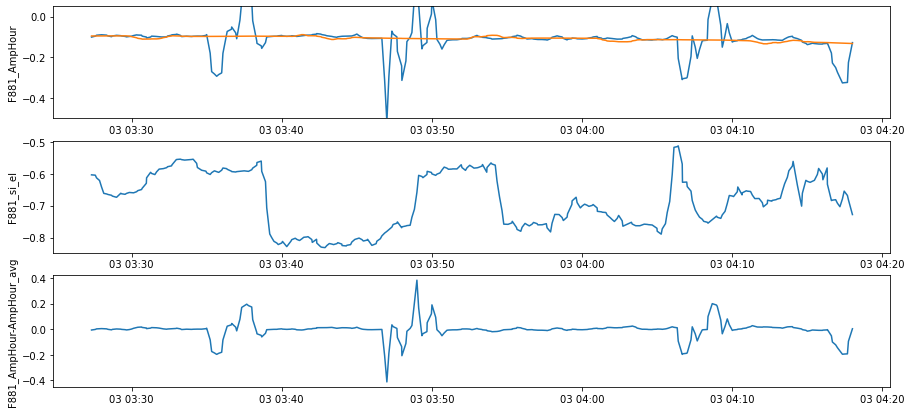

In [43]:
# single leg 
leg = 4
leg_data = data.loc[tms[leg]:tms[leg+1]]
N = len(leg_data)
leg_data = leg_data.iloc[int(0.15*N):int(0.85*N)]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

ax1.plot(leg_data.AmpHour)
ax1.set_ylim(-0.5,0.05)
ax1.set_ylabel('F'+str(fnum)+"_AmpHour")
ax1.plot(leg_data["AmpHour_avg"])

ax2.plot(leg_data.si_el)
ax2.set_ylabel('F'+str(fnum)+"_si_el")

ax3.plot(leg_data.AmpHour-leg_data.AmpHour_avg)
ax3.set_ylabel('F'+str(fnum)+"_AmpHour-AmpHour_avg")

In [29]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 7))

# ax1.plot(all_leg_data.AmpHour)
# ax1.set_ylim(-0.5,0.05)
# ax1.set_ylabel("AmpHour")
# ax1.plot(all_leg_data["AmpHour_avg"])

# ax2.plot(all_leg_data.si_el)
# ax2.set_ylabel("si_el")

# ax3.plot(all_leg_data.AmpHour-all_leg_data.AmpHour_avg)
# ax3.set_ylabel("AmpHour-AmpHour_avg")

# all_leg_data["AmpHourFluc"] = all_leg_data.AmpHour-all_leg_data.AmpHour_avg


# correaltion matrix
# corr = all_leg_data[["AmpHourFluc", "si_el", "si_xel", "si_los", "atc_el", "atc_xel", "atc_los"]].corr()
# f, ax = plt.subplots(figsize=(12, 10))
# mask = np.triu(np.ones_like(corr, dtype=bool))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, annot=True, mask = None, cmap=cmap)

In [59]:
# single leg 
def get_leg_data_corr(df_filled, tms, start, end, window=50):
    
    data = df_filled#.loc[tms[start]:tms[end]]
    data["AmpHour_avg"] = data.AmpHour.rolling(window=window, center=True).mean()

    leg_dict = {}

    for leg in range(start, end):

        leg_data = data.loc[tms[leg]:tms[leg+1]]
        N = len(leg_data)
        leg_data = leg_data.iloc[int(0.15*N):int(0.85*N)]

        leg_dict[leg] = leg_data

    all_leg_data = pd.concat([leg_data for leg, leg_data in leg_dict.items()])
    all_leg_data["AmpHourFluc"] = all_leg_data.AmpHour/all_leg_data.AmpHour_avg
    
    corr = all_leg_data[["AmpHourFluc", "si_el", "si_xel", "si_los", "atc_el", "atc_xel", "atc_los"]].corr()
    correlation = corr.loc["AmpHourFluc"].iloc[1:].to_dict()
    
    return correlation

<ipython-input-61-89f25fe0b040>:23: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later



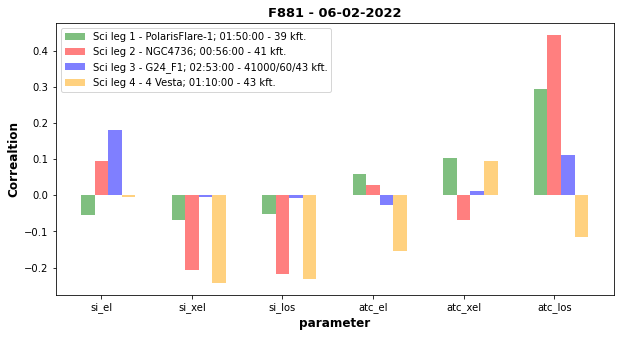

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

barWidth = 0.15

legs = [1, 2, 3, 4]
pallette = ["green", "red", "blue", "orange", "magenta", "purple"]
bar = np.arange(6)

for i, l in enumerate(legs):
    
    Corr = get_leg_data_corr(df_filled, tms, l, l+1, window=70) 
    ax.bar(bar, Corr.values(), color = pallette[i], width = barWidth, label="Sci leg {} - {}; {} - {} kft.".format(l,ltags[l],ldurs[l],alts[l]), alpha=0.5)
    bar = [x + barWidth for x in bar]


# Adding Xticks
ax.set_title('F{} - {}'.format(fnum,date), fontweight ='bold', fontsize = 13)
ax.set_xlabel('parameter', fontweight ='bold', fontsize = 12)
ax.set_ylabel('Correaltion', fontweight ='bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(Corr))], Corr.keys()) 
ax.legend()

plt.savefig(fp+'corr_F{}-{}.png'.format(fnum,date),tight_layout=True)

,level_0,index,atc_el,atc_xel,atc_los,si_el,si_xel,si_los,Time_sec,Temp_K,Resistence,Voltage,Current,C_120,AmpHour,AmpHour_avg
0,0,2022-06-02 21:30:52,0.000021,0.000005,0.000014,-0.626307,8.419971,-4.846577,34400.5365,0.169846,81592.50,-0.000525,1.455063,1.482222,-0.814763,NaN
1,1,2022-06-02 21:31:00,-0.000006,0.000012,0.000009,-0.631391,8.418419,-4.856826,34409.3360,0.169928,81487.00,-0.002600,1.454885,1.481017,-0.783960,NaN
2,2,2022-06-02 21:31:09,-0.000033,0.000018,0.000003,-0.636475,8.416868,-4.867074,34422.5680,0.172586,78490.75,-0.081625,1.447039,1.480227,-0.995640,NaN
3,3,2022-06-02 21:31:20,0.000017,-0.000005,-0.000003,-0.637974,8.401107,-4.853836,34435.8000,0.175245,75494.50,-0.160650,1.439193,1.479437,-1.207320,NaN
4,4,2022-06-02 21:31:26,0.000068,-0.000029,-0.000009,-0.639474,8.385346,-4.840598,34448.7750,0.171861,79436.25,-0.056820,1.446495,1.463548,-0.511605,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,2651,2022-06-03 04:28:13,-0.000188,-0.006881,0.003694,-0.385772,7.723324,-6.322530,59443.4690,0.169993,81404.00,-0.000295,0.212068,0.207896,0.125148,NaN
2652,2652,2022-06-03 04:28:20,0.005752,-0.004974,0.002696,-0.358784,7.666525,-6.301740,59452.1850,0.169969,81434.00,-0.000220,0.211789,0.207575,0.126411,NaN
2653,2653,2022-06-03 04:28:30,0.011692,-0.003067,0.001698,-0.331797,7.609726,-6.280950,59461.0700,0.170005,81388.50,-0.000665,0.211566,0.208908,0.079739,NaN
2654,2654,2022-06-03 04:28:40,0.001007,-0.003055,0.001978,-0.303376,7.578249,-6.208059,59469.9550,0.170041,81343.00,-0.001110,0.211343,0.210240,0.033067,NaN


In [58]:
import plotly.graph_objs as go
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots


primary_yax_title= 'SI XEL acceleration [m/s2]'
secondary_yax_title= 'ADR burn rate [A/h]'
xax_title = 'Datetime [UTC]'
plot_title = 'F881- 400 Hz sensor data'

trace1 = go.Scatter(
    y=data['si_xel'],
    x=data.index,
    name='SI Cross Elevation [m/s2]',
    yaxis='y1',
#     annotation_text="setup",
#     annotation_position="top left",
#     annotation_textangle = 90

)
trace2 = go.Scatter(
    y=data['AmpHour'],
    x=data.index,
    name='ADR burn rate [A/h]',
    yaxis='y2'

)
# title = '400 Hz sensor data'
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)

for i in range(3,len(leginfo)-2):
    legnum=i
    x=leginfo[legnum][0]+pd.DateOffset(days=1)+pd.DateOffset(hours=-7)
#     print(x, str(leginfo[legnum][1]))
    fig.add_vline(x, line_width=2, line_dash="dash", line_color="green"
             )

    
fig['layout'].update(height = 400, width = 1000, title = plot_title,xaxis=dict(tickangle=-90
    ))

# Set x-axis title
fig.update_xaxes(title_text=xax_title)

# Set y-axes titles
fig.update_yaxes(title_text=primary_yax_title, secondary_y=False,color='blue')
fig.update_yaxes(title_text=secondary_yax_title, secondary_y=True,range=[-0.6,0.6],color='red')


legnum=2
xl=leginfo[legnum][0]+pd.DateOffset(days=1)+pd.DateOffset(hours=-7)
fig.add_annotation(dict(font=dict(color='magenta',size=15),
                                        x=xl,
                                        y=7,
                                        showarrow=False,
                                        text="clear",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))

iplot(fig)

#---------------------------------------------

primary_yax_title= 'SI EL acceleration [m/s2]'
secondary_yax_title= 'ADR burn rate [A/h]'
xax_title = 'Datetime [UTC]'
# plot_title =  'F881-QUENTIN 400 Hz sensor data'

trace1 =  go.Scatter(
    x=data.index,
    y=data['si_el'],
    yaxis='y1',
    name='SI Cross Elevation acc. [m/s2]',
    line_dash=None

)
trace2 = go.Scatter(
    y=data['AmpHour'],
    x=data.index,
    yaxis='y2',
    name='ADR burn rate [A/h]'
    

)
# title = '400 Hz sensor data'
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 400, width = 1000, title = None,xaxis=dict(tickangle=-90
    ))

for i in range(3,len(leginfo)-2):
    legnum=i
    x=leginfo[legnum][0]+pd.DateOffset(days=1)+pd.DateOffset(hours=-7)
#     print(x, str(leginfo[legnum][1]))
    fig.add_vline(x, line_width=2, line_dash="dash", line_color="green"
             )


# Set x-axis title
fig.update_xaxes(title_text=xax_title)

# Set y-axes titles
fig.update_yaxes(title_text=primary_yax_title, secondary_y=False,color='blue')
fig.update_yaxes(title_text=secondary_yax_title, secondary_y=True,range=[-0.6,.6],color='red')

iplot(fig)

###-------------------------------

trace1 =  go.Scatter(
    x=data.index,
    y=data['si_los'],
    yaxis='y1',
    name='SI LOS acceleration [m/s2]',
    line_dash=None

)
trace2 = go.Scatter(
    y=data['AmpHour'],
    x=data.index,
    yaxis='y2',
    name='ADR burn rate [A/h]'

)
# title = '400 Hz sensor data'
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 400, width = 1000, title = None,xaxis=dict(tickangle=-90
    ))

for i in range(3,len(leginfo)-2):
    legnum=i
    x=leginfo[legnum][0]+pd.DateOffset(days=1)+pd.DateOffset(hours=-7)
#     print(x, str(leginfo[legnum][1]))
    fig.add_vline(x, line_width=2, line_dash="dash", line_color="green"
             )


# Set x-axis title
fig.update_xaxes(title_text=xax_title)

# Set y-axes titles
fig.update_yaxes(title_text=primary_yax_title, secondary_y=False,color='blue')
fig.update_yaxes(title_text=secondary_yax_title, secondary_y=True,range=[-0.6,0.6],color='red')

iplot(fig)